In [1]:
import pandas as pd
import numpy as np
import glob
import os
import pickle
import datetime
import matplotlib.pyplot as plt
from functools import reduce
import phik
import ppscore as pps

%matplotlib inline

In [2]:
FORECAST_PERIOD = 60

In [22]:
def load_data(files):
    
    # initiate dict to store data
    dfs = {}

    for f in files:

        # get name of the water body from the filename
        database = f.split('\\')[-1].replace('.csv','')
    
        # load the data
        df = pd.read_csv(f)

        # get start and end data of the data
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])

        # store data in dictionary by water body name
        dfs[database] = df
    
    return dfs

In [52]:
def plot_matrix(values, labels, title, vmin=0, vmax=1, save=False, method=False):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(values, vmin=vmin, vmax=vmax)
    ax = plt.gca()
    ax.set_xticks(range(0, len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(range(0, len(labels)))
    ax.set_yticklabels(labels, rotation=0)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()

    # save plot
    if save:
        if method:
            title = title + '_' + method
        plt.savefig('../figs/corr_%s.pdf'%(title.replace(' ','_').replace('-','_').replace('___','_')))

    return fig

def pearson_correlation(df, cols, target, rho):

    # select features with high correlation
    corr = df[cols].corr()
    feats = corr[corr[target].abs()>rho][target].sort_values(ascending=False).index
    
    # check whether at least 1 feature has been selected. If not, try again with smaller rho
    i=1
    while len(feats) < min(2, len(cols)-1):
        rho_adjusted = rho - i*0.1
        
        if rho_adjusted <= 0 : 
            print('No features with absolute correlation larger than %.2f. Stopping now'%(rho - (i-1)*0.1))
            break    
        
        print('No features selected for %s. Decreasing rho to %f and try again'%(target, rho_adjusted))
        feats = corr[corr[target].abs()>rho_adjusted][target].sort_values(ascending=False).index
        i = i + 1
    
    # calculate correlation matrix with only high correlation features
    corr_matrix_feats = df[feats].corr()
    
    return corr_matrix_feats

def phik_correlation(df, cols, target, rho):

    df = df.copy()
    
    # create categorical column based on month-columns
    df['month'] = df.filter(regex='month').idxmax(axis=1)
    cols = ['month'] + [c for c in cols if 'month' not in c]
    
    # select features with high correlation
    corr = df[cols].phik_matrix(verbose=False)
    feats = corr[corr[target]>rho][target].sort_values(ascending=False).index
    
    # check whether at least 1 feature has been selected. If not, try again with smaller rho
    i=1
    while len(feats) < min(2, len(cols)-1):
        rho_adjusted = rho - i*0.1
        
        if rho_adjusted <= 0 : 
            print('No features with a phik correlation larger than %.2f. Stopping now'%(rho - (i-1)*0.1))
            break    
        
        print('No features selected for %s. Decreasing rho to %f and try again'%(target, rho_adjusted))
        feats = corr[corr[target].abs()>rho_adjusted][target].sort_values(ascending=False).index
        i = i + 1
   
    # calculate correlation matrix with only high correlation features
    corr_matrix_feats = df[feats].phik_matrix(verbose=False)
    
    # drop month column
    df.drop(columns=['month'], inplace=True)
    
    return corr_matrix_feats


def ppstable_to_ppsmatrix(dftable):
    
    cols = dftable['x'].unique()
    dftable.set_index(['x','y'], inplace=True)
    
    ppsmatrix = pd.DataFrame(index=cols, columns=cols)
    for x in cols:
        for y in cols:
            ppsmatrix.loc[x, y] = dftable.loc[(x, y), 'ppscore']
            
    ppsmatrix = ppsmatrix.astype(float)
            
    return ppsmatrix

def pps_correlation(df, cols, target, rho):
    
    df = df.copy()
    
    # create categorical column based on month-columns
    df['month'] = df.filter(regex='month').idxmax(axis=1)
    cols = ['month'] + [c for c in cols if 'month' not in c]

    
    ppstable = pps.matrix(df[cols])
    corr = ppstable_to_ppsmatrix(ppstable)
    feats = corr[corr[target]>rho][target].sort_values(ascending=False).index
    
    # check whether at least 1 feature has been selected. If not, try again with smaller rho
    i=1
    while len(feats) < min(2, len(cols)-1):
        rho_adjusted = rho - i*0.1
        
        if rho_adjusted <= 0 : 
            print('No features with predictive power score larger than %.2f. Stopping now'%(rho - (i-1)*0.1))
            break    
        
        print('No features selected for %s. Decreasing rho to %f and try again'%(target, rho_adjusted))
        feats = corr[corr[target].abs()>rho_adjusted][target].sort_values(ascending=False).index
        i = i + 1
   
    ppstable = pps.matrix(df[feats])
    corr_matrix_feats = ppstable_to_ppsmatrix(ppstable)
    
    # drop month column
    df.drop(columns=['month'], inplace=True)

    
    return corr_matrix_feats.T
    
    
def select_features(df, targets, name, method='pearson', rho=0.4, save=False, echo=False):
    
    features = {}
    
    if isinstance(rho, float):
        rho = [rho] * len(targets)
    
    for target, r in zip(targets, rho):

        cols = (set(df.columns) - set(targets) - set(['Date'])) | set([target])

        if method == 'pearson':
            
            corr_matrix_feats = pearson_correlation(df, cols, target, r)
            vmin=-1

        elif method == 'phik':
            
            if echo:
                print('Calculate phik correlation for %s - %s'%(name, target))
            
            corr_matrix_feats = phik_correlation(df, cols, target, r)
            vmin=0
            
        elif method == 'pps':
            
            if echo:
                print('Calculate pps correlation for %s - %s'%(name, target))
            
            corr_matrix_feats = pps_correlation(df, cols, target, r)
            vmin=0
            
        features[target] = corr_matrix_feats.columns
        
        # plot correlation matrix
        title = '%s - %s'%(name.replace('_',' '), target)
        plot_matrix(corr_matrix_feats, corr_matrix_feats.columns, title, vmin=vmin, save=save, method=method)
        
    return features
    
    


In [24]:
def create_features_dataset(features, dfs, datadir, selection_method):
    
    if not os.path.exists(os.path.join(datadir, selection_method)):
        print('Create folder', os.path.join(datadir, selection_method))
        os.makedirs(os.path.join(datadir, selection_method))
    
    for waterbody in features.keys():
        df = dfs[waterbody]
        for target in features[waterbody].keys():
            filename = '%s_%s.csv'%(waterbody, target)
            cols = list(features[waterbody][target].values) + ['Date']
            if 'month' in cols:
                cols = [c for c in cols if c != 'month'] + ['month_%d'%i for i in range(1, 12)]
            df[cols].dropna().to_csv(os.path.join(datadir, selection_method, filename), index=False)
    return
            

# Load data

In [42]:
datadir = '../data/'
cleandir = os.path.join(datadir, 'clean')
featsengdir = os.path.join(datadir, 'featseng', 'D%d'%FORECAST_PERIOD)
featsdir = os.path.join(datadir, 'feats', 'D%d'%FORECAST_PERIOD)

In [43]:
files = glob.glob(os.path.join(featsengdir, '*.csv'))
filename_cols = glob.glob(os.path.join(cleandir, '*.xlsx'))[0]

In [44]:
dfs = load_data(files)
names = [c.replace('D7_','') for c in list(dfs.keys())]

dfcols = pd.read_excel(filename_cols, engine='openpyxl')

In [45]:
names

['Aquifer_Auser', 'Aquifer_Petrignano', 'Lake_Bilancino', 'River_Arno']

# Inspect relation between target and features

**Methods**

- pearson correlation  (note: only linear correlations!)
- phik correlation
- predictive power score

**Observations**

- The selected features are in most cases highly correlated to eachother. This is not surprising as lagged features are used

### Pearson correlation

No features selected for Flow_Rate. Decreasing rho to 0.300000 and try again
No features selected for Flow_Rate. Decreasing rho to 0.200000 and try again
No features selected for Hydrometry_Nave_di_Rosano. Decreasing rho to 0.300000 and try again


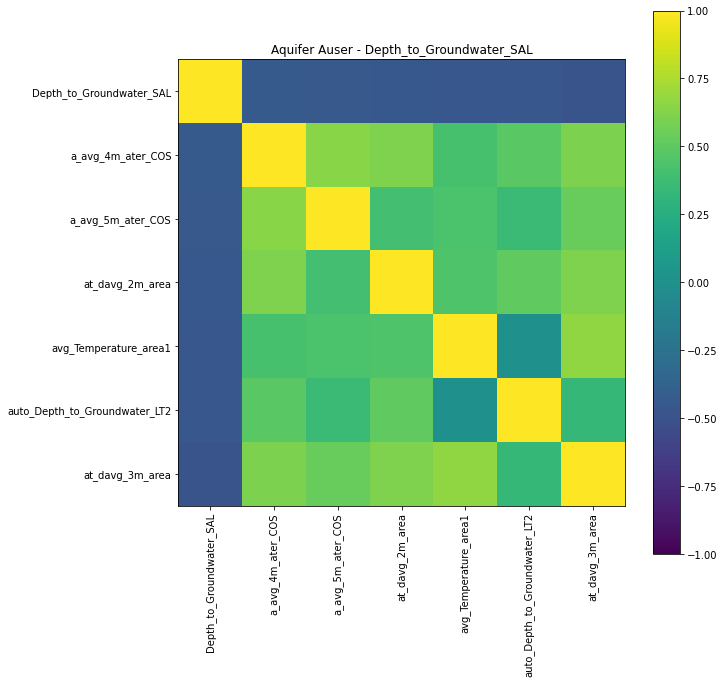

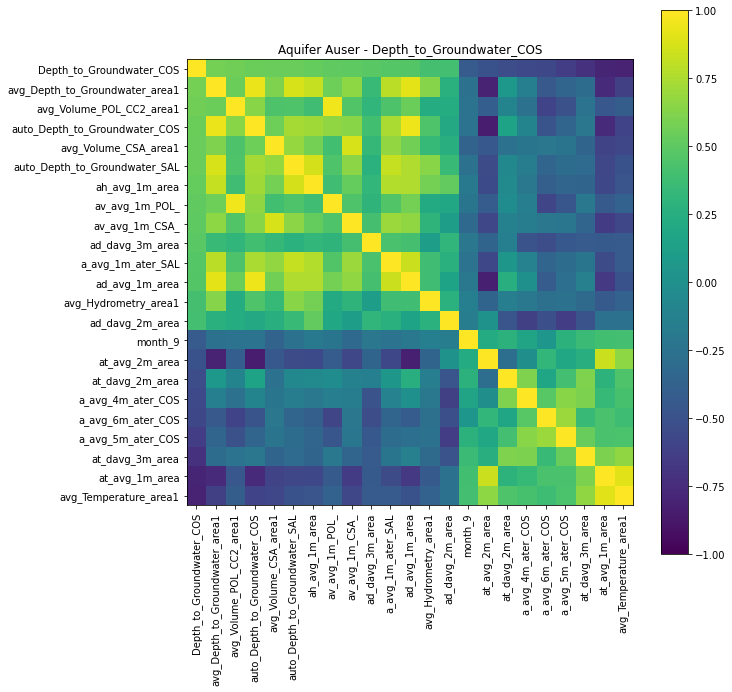

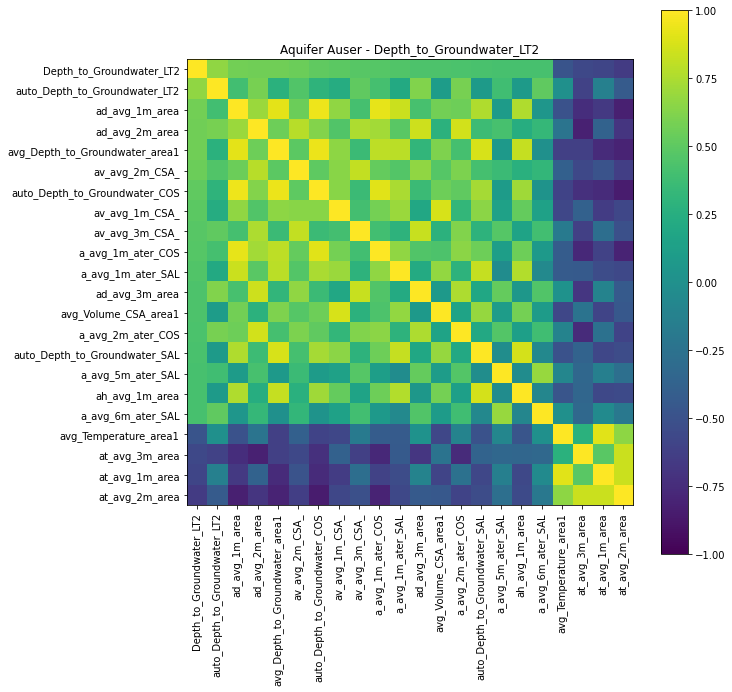

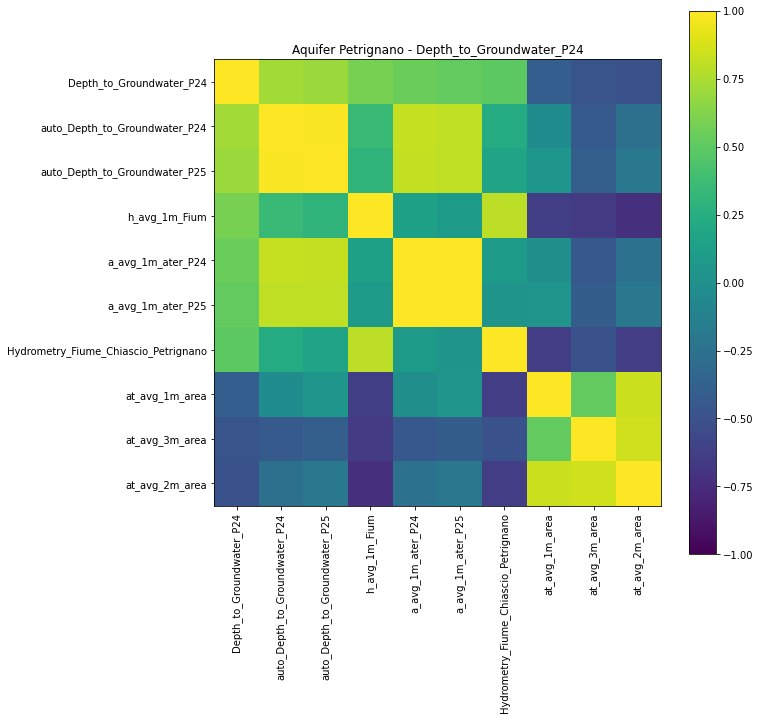

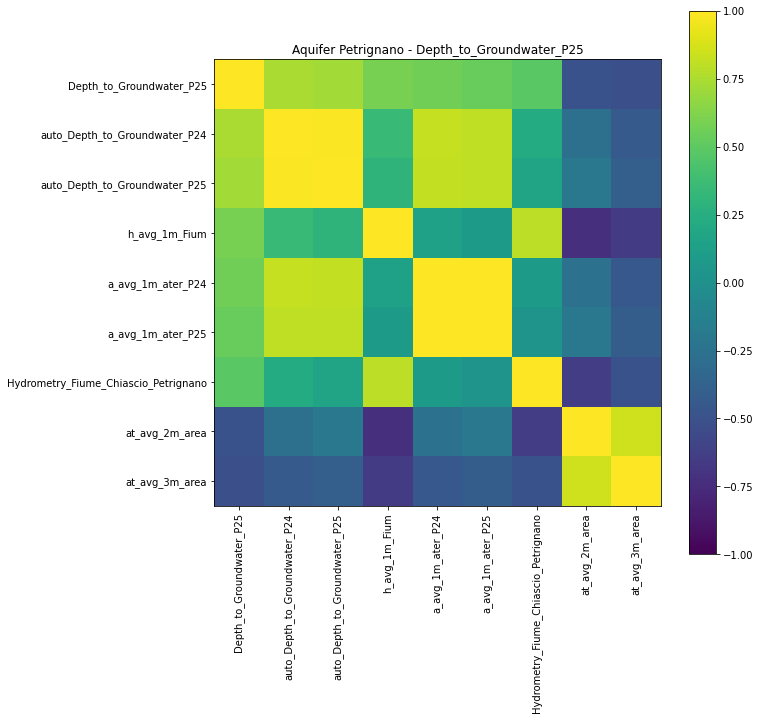

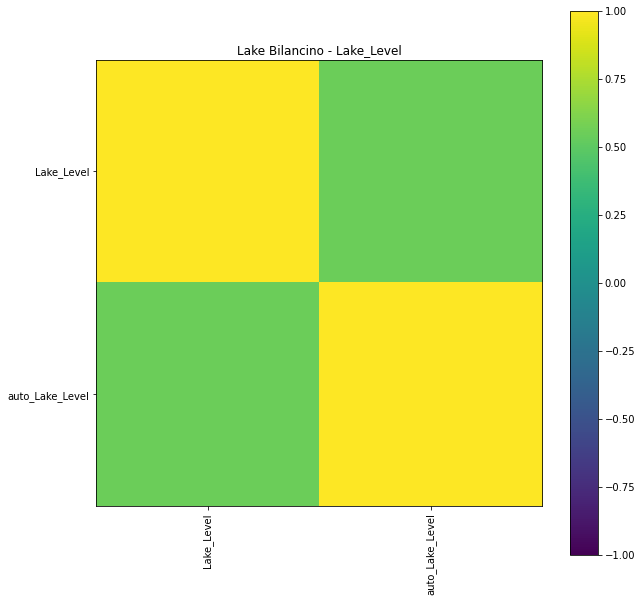

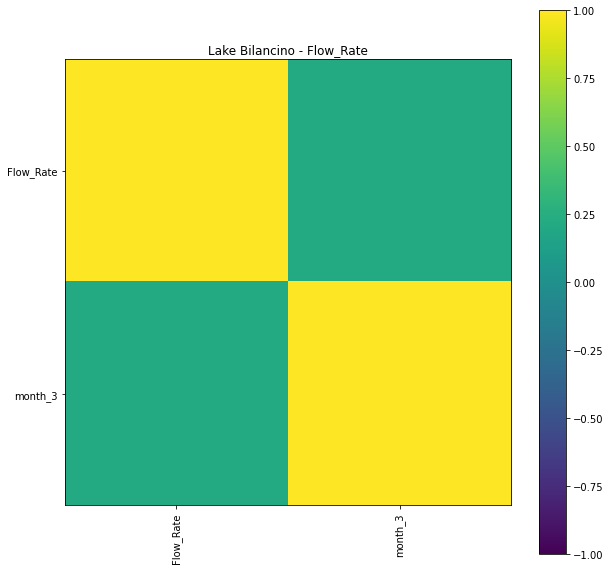

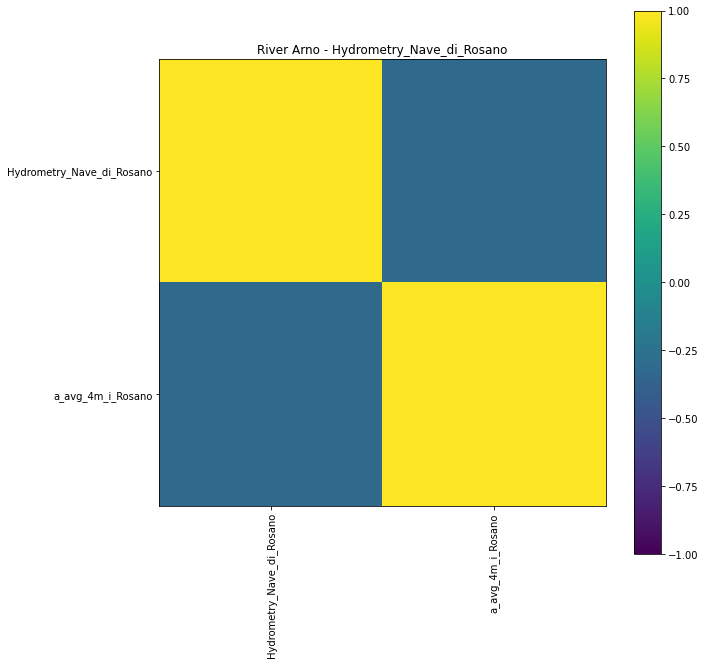

In [10]:
features_pearson = {}
rho=0.4

for name in names:
    
    df = dfs[name]
    targets = dfcols[(dfcols['name']==name) & (dfcols['coltype']=='target')]['colname'].unique()
    features_pearson[name] = select_features(df, targets, name, rho=rho, method='pearson', save=True)

### Phik correlation

In [11]:
names

['Aquifer_Auser', 'Aquifer_Petrignano', 'Lake_Bilancino', 'River_Arno']

Calculate phik correlation for Aquifer_Auser - Depth_to_Groundwater_SAL
No features selected for Depth_to_Groundwater_SAL. Decreasing rho to 0.700000 and try again
Calculate phik correlation for Aquifer_Auser - Depth_to_Groundwater_COS
Calculate phik correlation for Aquifer_Auser - Depth_to_Groundwater_LT2
Calculate phik correlation for Aquifer_Petrignano - Depth_to_Groundwater_P24
Calculate phik correlation for Aquifer_Petrignano - Depth_to_Groundwater_P25
Calculate phik correlation for Lake_Bilancino - Lake_Level
Calculate phik correlation for Lake_Bilancino - Flow_Rate
No features selected for Flow_Rate. Decreasing rho to 0.400000 and try again
No features selected for Flow_Rate. Decreasing rho to 0.300000 and try again
Calculate phik correlation for River_Arno - Hydrometry_Nave_di_Rosano


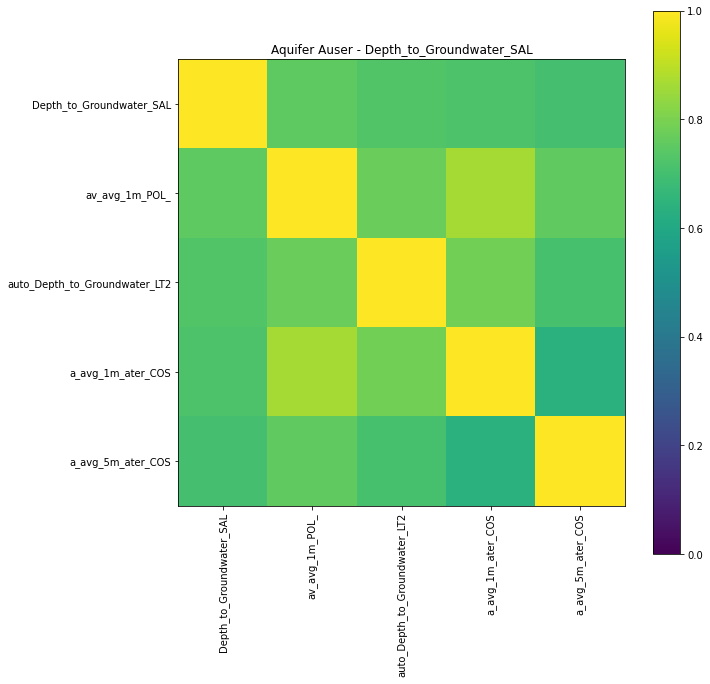

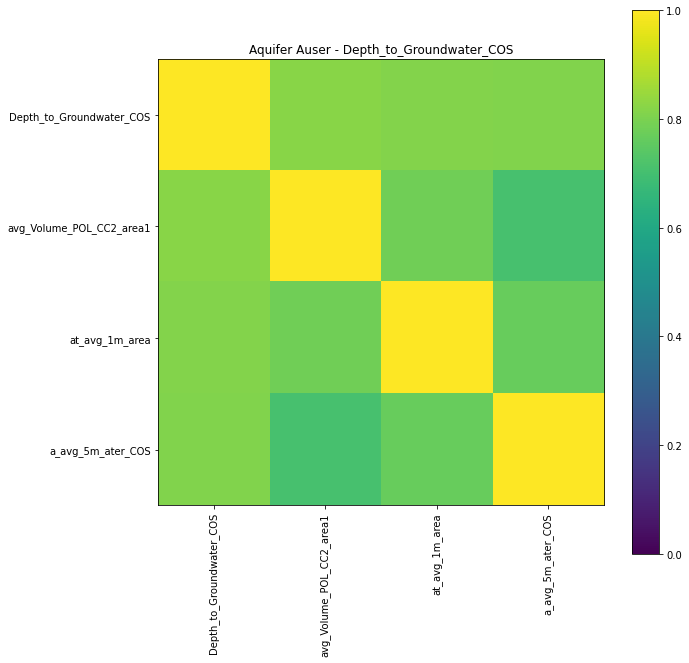

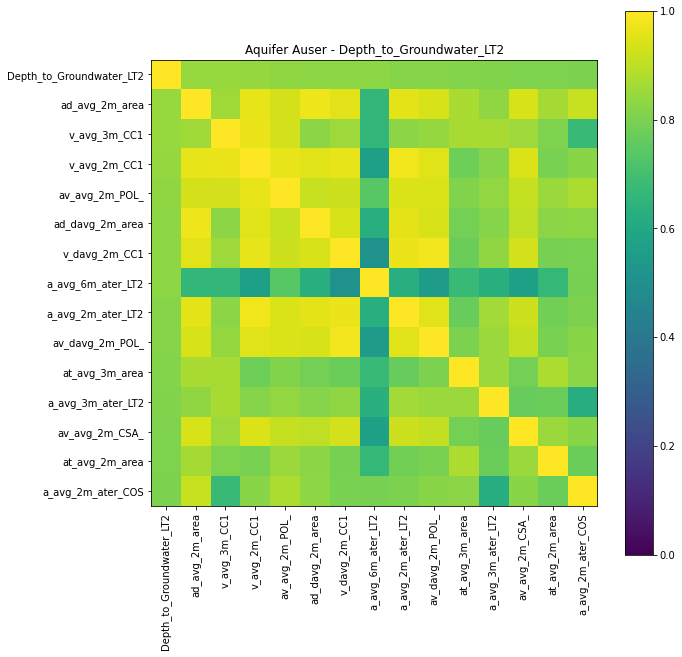

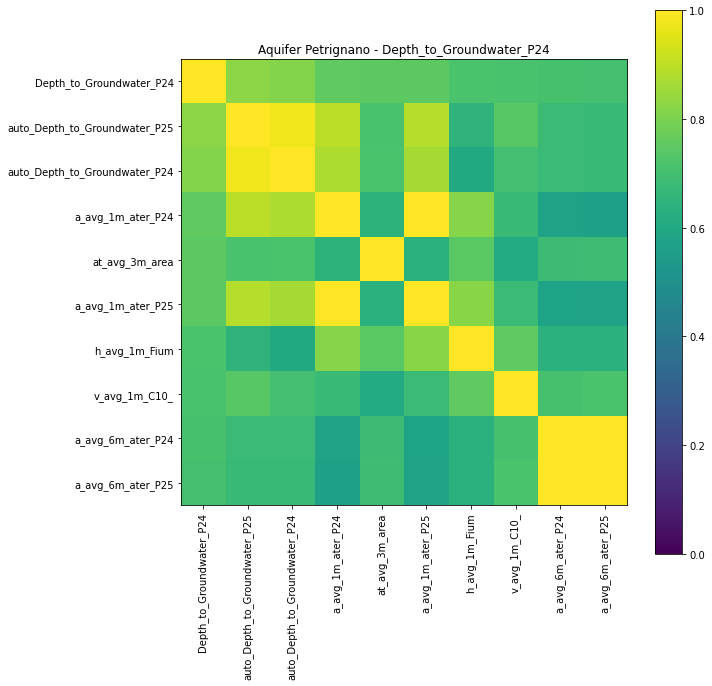

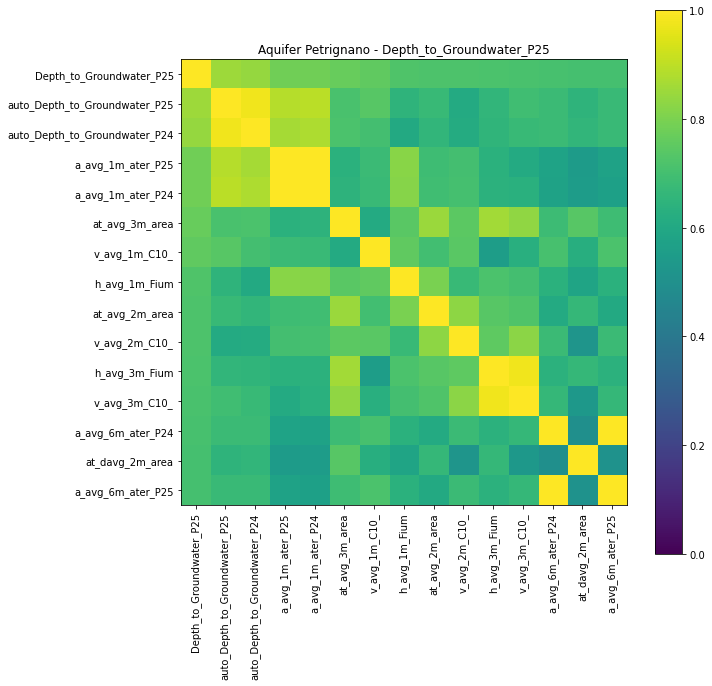

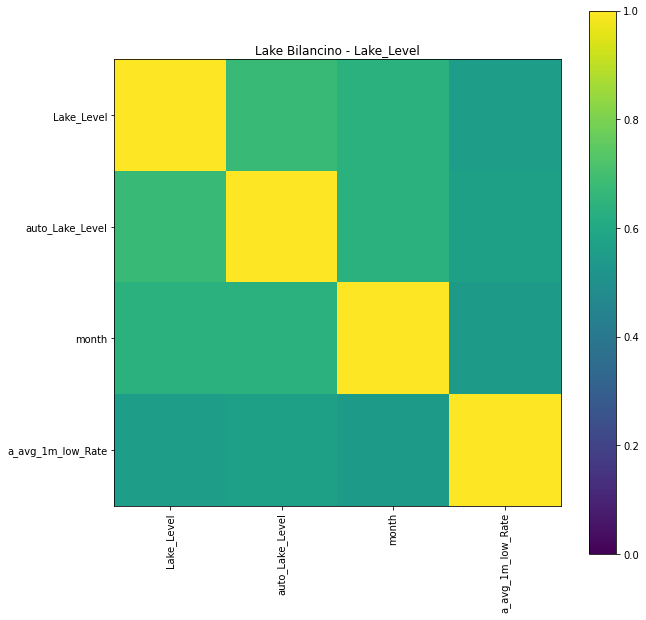

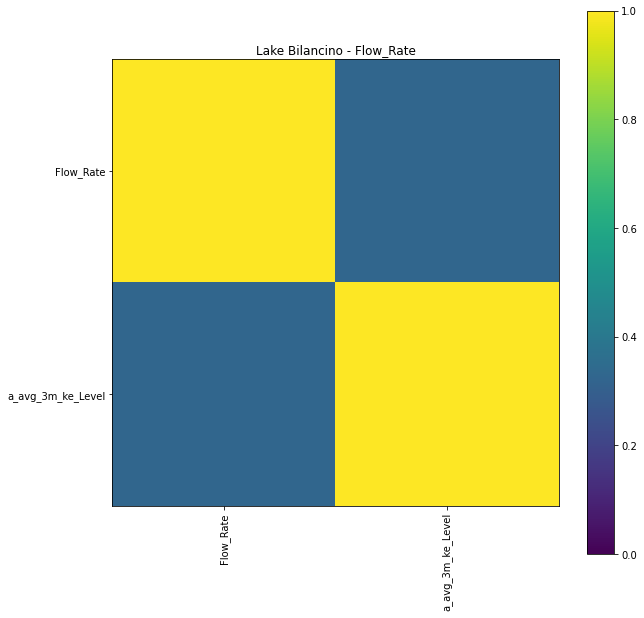

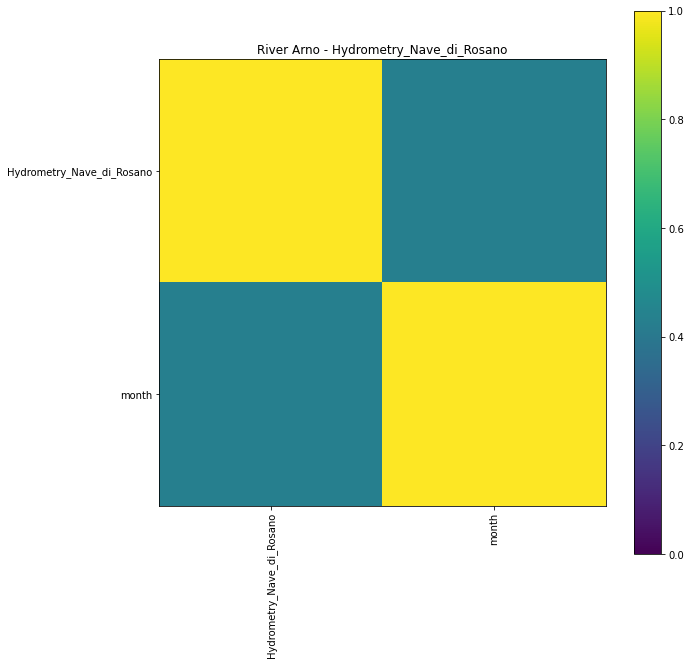

In [15]:
features_phik = {}
rho = {'Aquifer_Auser': 0.8, #0.8 is used in modelling
       'Aquifer_Petrignano':0.7, 
       'Lake_Bilancino':0.5, 
       'River_Arno':0.4}

for name in names:
    
    df = dfs[name]
    targets = dfcols[(dfcols['name']==name) & (dfcols['coltype']=='target')]['colname'].unique()
    features_phik[name] = select_features(df, targets, name, rho=rho[name], method='phik', echo=True, save=True)

### Predictive power score

Calculate pps correlation for Aquifer_Auser - Depth_to_Groundwater_SAL
Calculate pps correlation for Aquifer_Auser - Depth_to_Groundwater_COS
Calculate pps correlation for Aquifer_Auser - Depth_to_Groundwater_LT2
Calculate pps correlation for Aquifer_Petrignano - Depth_to_Groundwater_P24
No features selected for Depth_to_Groundwater_P24. Decreasing rho to 0.200000 and try again
Calculate pps correlation for Aquifer_Petrignano - Depth_to_Groundwater_P25
Calculate pps correlation for Lake_Bilancino - Lake_Level
Calculate pps correlation for Lake_Bilancino - Flow_Rate
No features selected for Flow_Rate. Decreasing rho to 0.100000 and try again
No features with predictive power score larger than 0.10. Stopping now
Calculate pps correlation for River_Arno - Hydrometry_Nave_di_Rosano


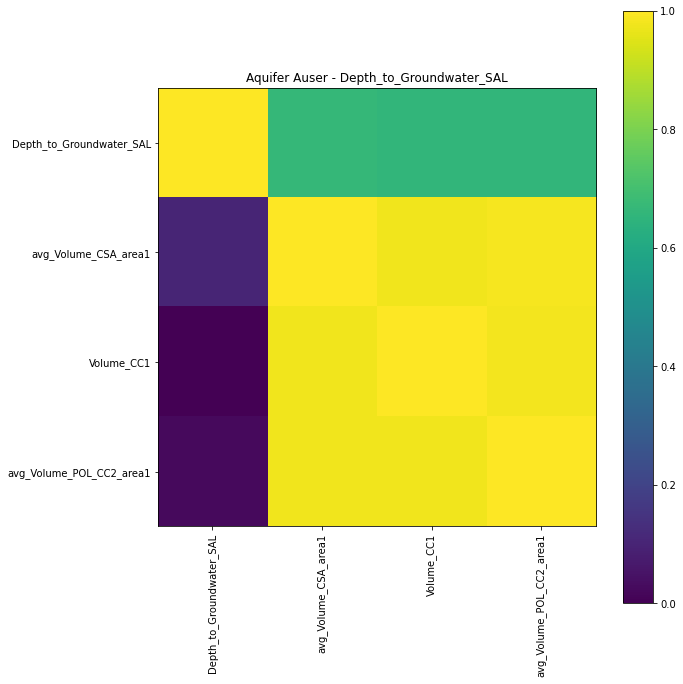

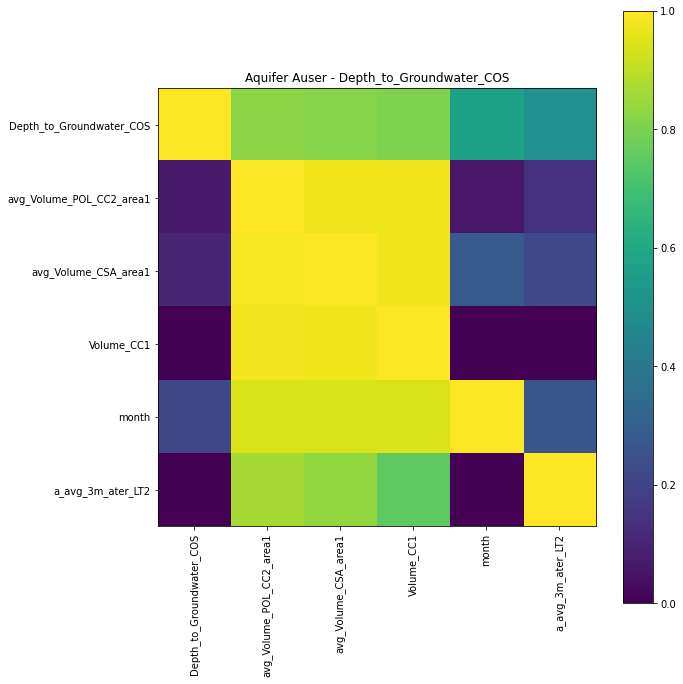

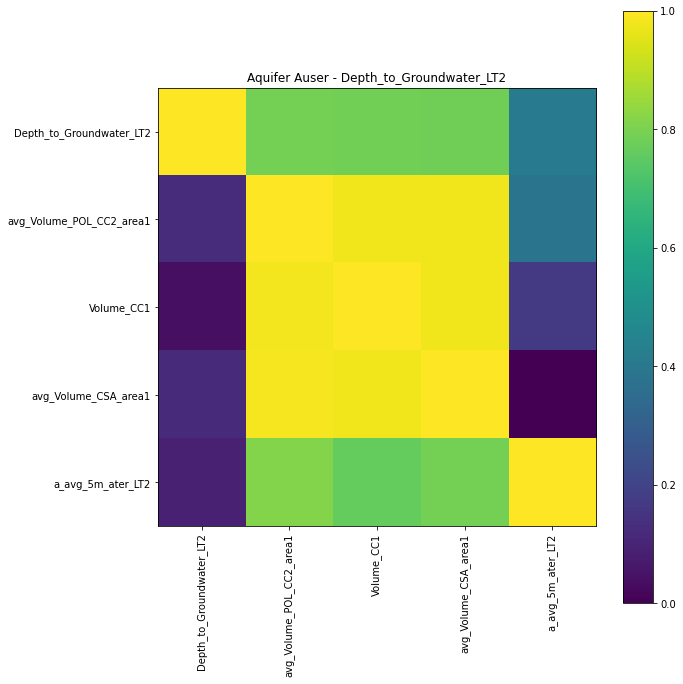

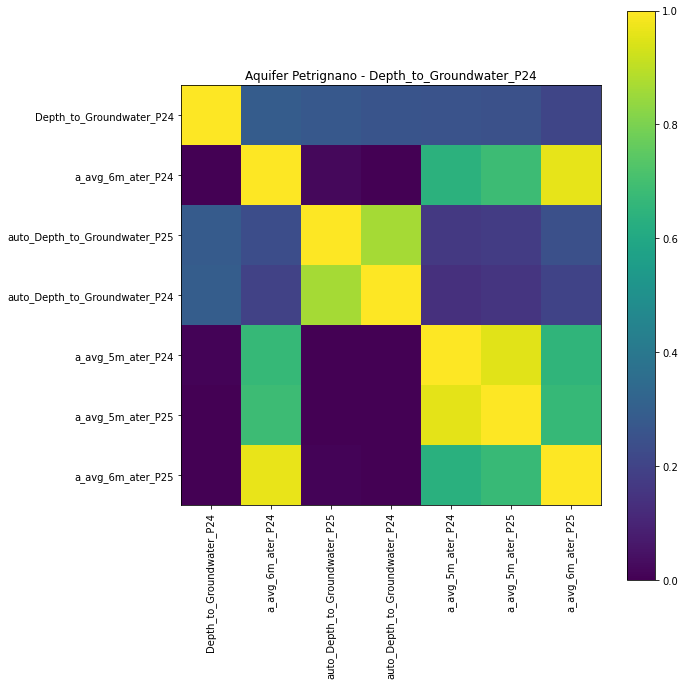

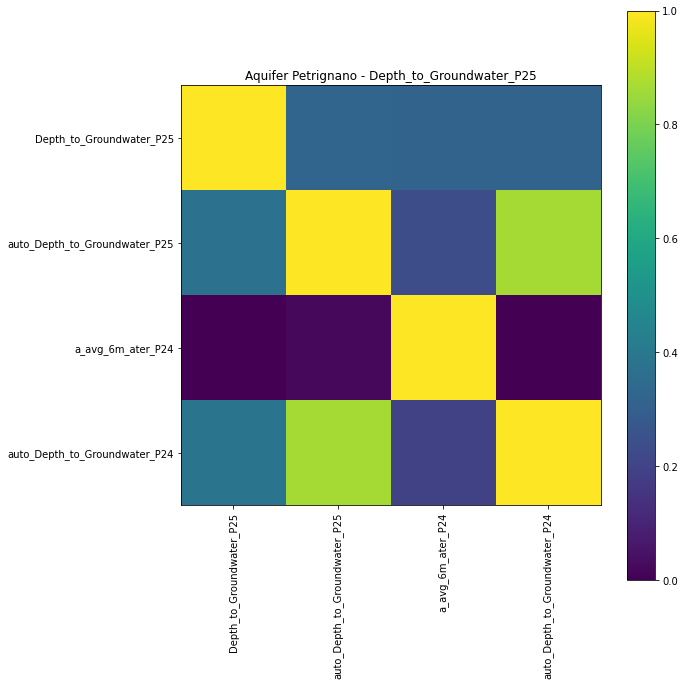

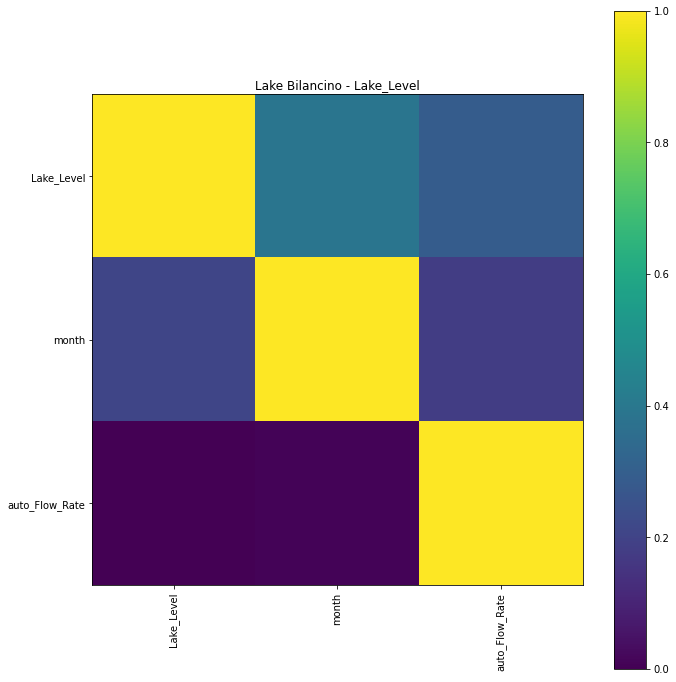

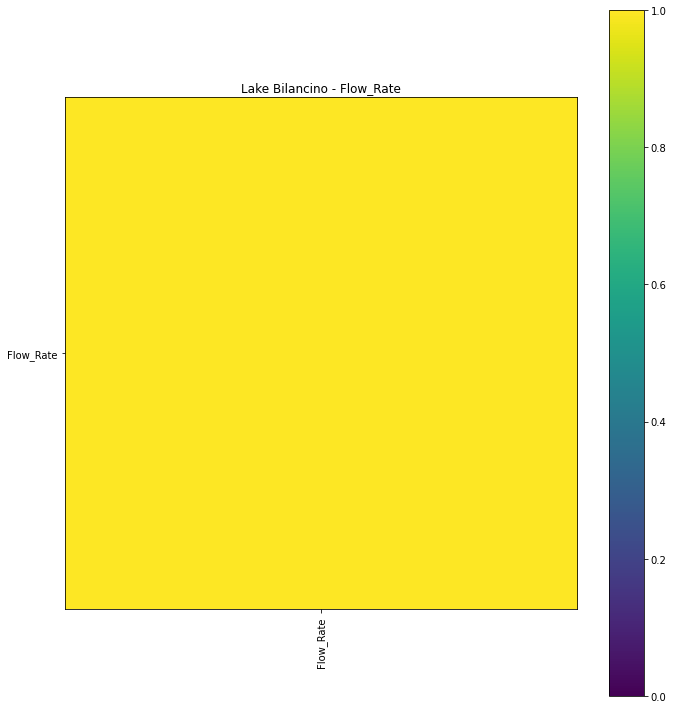

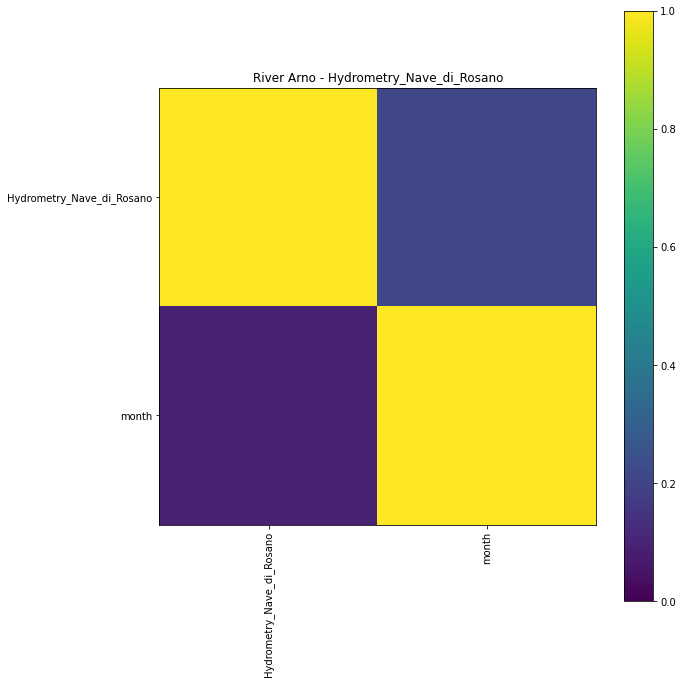

In [54]:
features_pps = {}
rho = {'Aquifer_Auser': 0.4, 
       'Aquifer_Petrignano':0.3, 
       'Lake_Bilancino':0.2, 
       'River_Arno':0.1}

for name in names:
    
    df = dfs[name]
    targets = dfcols[(dfcols['name']==name) & (dfcols['coltype']=='target')]['colname'].unique()
    features_pps[name] = select_features(df, targets, name, rho=rho[name], method='pps', echo=True, save=True)
    

## Inspect selected features

**Observations**

- There is great overlap between the features selected by all methods
- Phik tends to select some features which are not selected by Pearson. This can be explained by the fact that the phik-correlation captures non-linear relations while Pearson only captures linear dependencies
- For some waterbodies more features are selected by the pearson correlation compared to the phik correlation. This can be explained by the fact that the phik correlation is set to a more tight value (0.6) compared to the pearson correlation (0.4) in order to reduce the number of selected features
- The predictive power score does not select any additional features compared to those selected by either Pearson or phik correlation


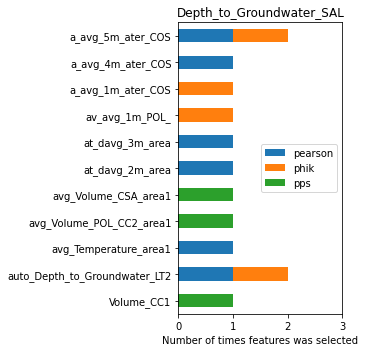

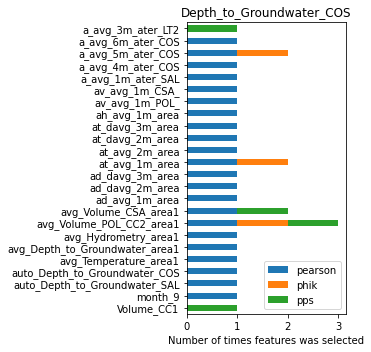

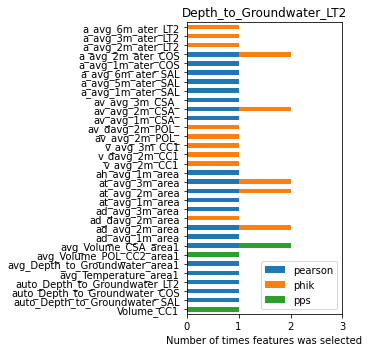

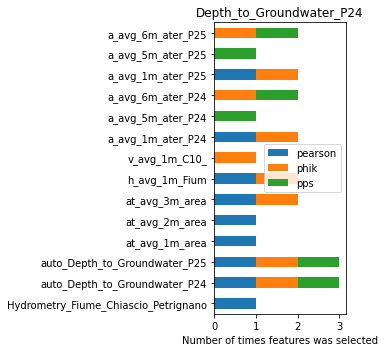

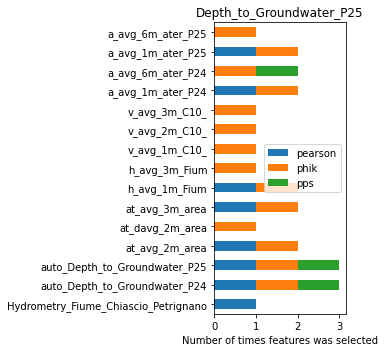

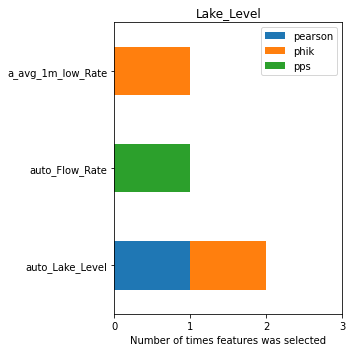

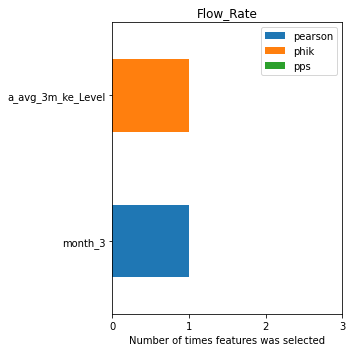

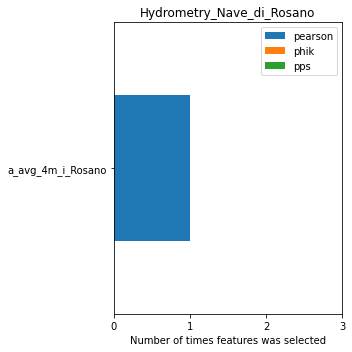

In [53]:
for name in names:
    
    df = dfs[name]
    
    for target in features_pearson[name].keys():
        cols = df.drop(columns=[target, 'Date']).columns

        val_pearson = [1 if c in features_pearson[name][target] else 0 for c in cols]
        val_phik = [1 if c in features_phik[name][target] else 0 for c in cols]
        val_pps = [1 if c in features_pps[name][target] else 0 for c in cols]
            
        dfvals = pd.DataFrame({'pearson': val_pearson,
                               'phik': val_phik,
                               'pps': val_pps}, index=cols).replace(0,np.nan).dropna(how='all').replace(np.nan, 0).plot(kind='barh', stacked=True, figsize=(5,5))
        plt.title(target)
        plt.xlabel('Number of times features was selected')
        ax = plt.gca()
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels([0,1,2,3])
        plt.tight_layout()
        plt.savefig('figs/feature_selection_summary_%s.pdf'%(name + '_' + target))

## Create dataset per waterbody per target

- For now I will use the features that were automatically selected based on pearson, phik or pps metrics

In [116]:
create_features_dataset(features_pearson, dfs, os.path.join(featsdir, 'automatic'), 'pearson')
create_features_dataset(features_phik, dfs, os.path.join(featsdir, 'automatic'), 'phik')
create_features_dataset(features_pps, dfs, os.path.join(featsdir, 'automatic'), 'pps')

Create folder ../data/feats\D60\automatic\pps


# Manual selection

In [121]:
for name in names:
    
    df = dfs[name]
    targets = dfcols[(dfcols['name']==name) & (dfcols['coltype']=='target')]['colname'].unique()
    features = (set(df.columns) - set(targets) - set(['Date'])) | set([target])
    print('#'*30)
    print(name)
    print('-'*30)
    print(sorted(targets))
    print('-'*30)
    print(sorted(features))

##############################
Aquifer_Auser
------------------------------
['Depth_to_Groundwater_COS', 'Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL']
------------------------------
['Hydrometry_Nave_di_Rosano', 'Rainfall_Croce_Arcana', 'Rainfall_Fabbriche_di_Vallico', 'Rainfall_Tereglio_Coreglia_Antelminelli', 'Volume_CC1', 'a_avg_1m_ater_COS', 'a_avg_1m_ater_LT2', 'a_avg_1m_ater_SAL', 'a_avg_2m_ater_COS', 'a_avg_2m_ater_LT2', 'a_avg_2m_ater_SAL', 'a_avg_3m_ater_COS', 'a_avg_3m_ater_LT2', 'a_avg_3m_ater_SAL', 'a_avg_4m_ater_COS', 'a_avg_4m_ater_LT2', 'a_avg_4m_ater_SAL', 'a_avg_5m_ater_COS', 'a_avg_5m_ater_LT2', 'a_avg_5m_ater_SAL', 'a_avg_6m_ater_COS', 'a_avg_6m_ater_LT2', 'a_avg_6m_ater_SAL', 'ad_avg_1m_area', 'ad_avg_2m_area', 'ad_avg_3m_area', 'ad_davg_2m_area', 'ad_davg_3m_area', 'ah_avg_1m_area', 'ah_avg_2m_area', 'ah_avg_3m_area', 'ah_davg_2m_area', 'ah_davg_3m_area', 'ar_dsum_2w_area', 'ar_dsum_3w_area', 'ar_sum_1w_area', 'ar_sum_2w_area', 'ar_sum_3w_area', 'at_avg_1

In [128]:
Aquifer_Auser_Depth_to_Groundwater_COS = ['avg_Depth_to_Groundwater_area1', 'avg_Volume_POL_CC2_area1', 'ad_avg_2m_area', 
                                          'ad_avg_3m_area', 'avg_Temperature_area1']
Aquifer_Auser_Depth_to_Groundwater_LT2 = ['ad_avg_2m_area', 'a_avg_6m_ater_LT2', 'a_avg_3m_ater_LT2', 'avg_Temperature_area1']
Aquifer_Auser_Depth_to_Groundwater_SAL = ['avg_Temperature_area1', 'a_avg_5m_ater_COS','a_avg_4m_ater_COS','av_avg_1m_POL_',
                                          'auto_Depth_to_Groundwater_SAL']
Aquifer_Petrignano_P24 = ['auto_Depth_to_Groundwater_P24','at_avg_3m_area','h_avg_1m_Fium', 'v_avg_1m_C10_', 'a_avg_6m_ater_P24']
Aquifer_Petrignano_P25 = ['auto_Depth_to_Groundwater_P25','at_avg_3m_area','v_avg_1m_C10_','h_avg_1m_Fium', 'v_avg_2m_C10_']
Lake_Bilancino_Lake_Level = ['auto_Lake_Level','a_avg_1m_low_Rate','avg_Rainfall_area1']
Lake_Bilancino_Flow_Rate = ['a_avg_3m_ke_Level','auto_Lake_Level', 'avg_Rainfall_area1']
River_Arno_Hydrometry_Nave_di_Rosano = ['a_avg_4m_i_Rosano','auto_Hydrometry_Nave_di_Rosano']


feats_dict = {
    'Aquifer_Auser': {
        'Depth_to_Groundwater_COS': Aquifer_Auser_Depth_to_Groundwater_COS,
        'Depth_to_Groundwater_LT2': Aquifer_Auser_Depth_to_Groundwater_LT2,
        'Depth_to_Groundwater_SAL': Aquifer_Auser_Depth_to_Groundwater_SAL
    },
    'Aquifer_Petrignano': {
        'Depth_to_Groundwater_P24': Aquifer_Petrignano_P24,
        'Depth_to_Groundwater_P25': Aquifer_Petrignano_P25,
    },
    'Lake_Bilancino': {
        'Lake_Level': Lake_Bilancino_Lake_Level,
        'Flow_Rate': Lake_Bilancino_Flow_Rate,
    },
    'River_Arno': {
        'Hydrometry_Nave_di_Rosano': River_Arno_Hydrometry_Nave_di_Rosano
    }
    
}

In [129]:
for name in names:
    
    df = dfs[name]
    targets = dfcols[(dfcols['name']==name) & (dfcols['coltype']=='target')]['colname'].unique()
    features = (set(df.columns) - set(targets) - set(['Date'])) | set([target])
    print('#'*30)
    print(name)
    print('-'*30)
    for target in targets:
        feats_sel = feats_dict[name][target]
        if np.all([f in features for f in feats_sel]):
            print('OK       ', target)
        else:
            print('NOT OK   ', target, '    ', [f  for f in feats_sel if f not in features])


##############################
Aquifer_Auser
------------------------------
OK        Depth_to_Groundwater_SAL
OK        Depth_to_Groundwater_COS
OK        Depth_to_Groundwater_LT2
##############################
Aquifer_Petrignano
------------------------------
OK        Depth_to_Groundwater_P24
OK        Depth_to_Groundwater_P25
##############################
Lake_Bilancino
------------------------------
OK        Lake_Level
OK        Flow_Rate
##############################
River_Arno
------------------------------
OK        Hydrometry_Nave_di_Rosano


In [132]:
pickle.dump(feats_dict, open(os.path.join('../data', 'feats','D%d'%FORECAST_PERIOD, 'manual', 'features.p'), 'wb'))

In [136]:
months = ['month_%d'%i for i in range(1, 13)]

for body in feats_dict.keys():
    df = dfs[body]
    for target in feats_dict[body]:
        name = '%s_%s'%(body, target)
        filename = os.path.join(datadir, 'feats', 'D%d'%FORECAST_PERIOD, 'manual', name + '.csv')
        df[[target] + feats_dict[body][target] + months + ['Date']].to_csv(filename, index=False)